In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wurtzite as wzt
from wurtzite.model import DislocationDef

In [2]:
# dislocations2.py

# glowne zmiany:
# zaimplemenowany RN
# displace_love2: uwzglednia przesuniecia be/2, bz/2

import numpy as np
from wurtzite.model import Crystal
from typing import Tuple, Union, Sequence


def love_function2(x: np.ndarray, be: float, bz: float) -> np.ndarray:
    x1 = x[..., 0]  # (n_atoms, )
    x2 = x[..., 1]  # (n_atoms, )
    r2 = x1**2 + x2**2
    r = np.sqrt(r2)
    x1_norm = x1/r
    x2_norm = x2/r
    r02 = RADIUS_FACTOR*be**2

    ux = be/(2*np.pi)*(np.arctan2(x2_norm, x1_norm)+ x1_norm*x2_norm/(2.0*(1-NU))) - be/2
    uy = -be/(8*np.pi*(1-NU)) * ((1.0-NU-NU)*np.log(r2/r02) + (x1_norm+x2_norm)*(x1_norm-x2_norm))
    uz = bz/(2*np.pi)*np.arctan2(x2_norm, x1_norm) - bz/2

    ux = ux.reshape(-1, 1)  # (natoms, 1)
    uy = uy.reshape(-1, 1)  # (natoms, 1)
    uz = uz.reshape(-1, 1)  # (natoms, 1)
    return np.column_stack((ux, uy, uz))  # (natoms, 3)
    

def newton_raphson(x0, n_iter, f, jacobian, lr=1.0, **kwargs):
    x = x0
    xs = []
    xs.append(x0)
    for i in range(n_iter):
        j = jacobian(x, **kwargs)
        o = f(x, **kwargs)
        x  = x - lr*np.linalg.inv(j).dot(o)
        xs.append(x)
    return x, xs


def displace_love2(
        crystal: Crystal,
        position: Union[Sequence[float], np.ndarray],
        burgers_vector: Union[Sequence[float], np.ndarray],
        plane: Union[Sequence[float], np.ndarray],
        l_function=wzt.dislocations.love_function,
        bv_fraction: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray]:
    position = np.asarray(position)
    burgers_vector = np.asarray(burgers_vector)
    plane = np.asarray(plane)
    cell = crystal.cell

    rt = wzt.dislocations._get_rotation_tensor(
        burgers_vector=burgers_vector,
        plane=plane,
        cell=cell
    )
    rt_inv = np.transpose(rt)

    burgers_vector = bv_fraction * cell.to_cartesian_indices(burgers_vector)
    burgers_vector = burgers_vector.reshape(-1, 1)
    burgers_vector = rt.dot(burgers_vector).squeeze()
    be = np.sqrt(burgers_vector[0]**2 + burgers_vector[1]**2)
    bz = burgers_vector[2]

    position = position.reshape(-1, 1)
    cd = rt.dot(position).squeeze()  # (3, )

    # Initial setting
    x_all = rt.dot(crystal.coordinates.T).T  # (natoms, 3)
    x_all = x_all-cd.reshape(1, -1)
    # x_distance = x_all-cd

    def f(u, x):
        nonlocal be, bz
        current_x = x+u
        current_x = current_x.reshape(1, -1)
        return u-l_function(current_x, be, bz).squeeze()

    def jacobian(u, x):
        nonlocal be, bz
        current_x = x + u
        current_x = current_x.reshape(1, -1)
        BETA_ONES = np.eye(3)
        BETA_ONES[-1, -1] = 0
        return BETA_ONES-wzt.dislocations.beta_function(current_x, be, bz).squeeze()

    result_u = np.zeros((crystal.n_atoms, 3))

    all_us = []
    for i, coords in enumerate(x_all):
        u0 = np.zeros(3)
        u, us = newton_raphson(x0=u0, n_iter=10, f=f, jacobian=jacobian, x=coords)
        result_u[i] = u
        all_us.append(np.stack(us))
        
    all_us = np.stack(all_us)  # (n atoms, timestep, 3)
    all_us = np.transpose(all_us, (1, 0, 2))  # (timestep, n atoms, 3)
    # Move to the previous system 
    result_u = rt_inv.dot(result_u.T).T
    return result_u, all_us

In [3]:
import wurtzite

def display_tee_2d(ax, d: wurtzite.model.DislocationDef, line_width=6, zorder=10000, scale=1.0, fontsize="medium",
                   label_offset: tuple = (0, -1)):
    line_width *= scale
    pos, b = np.asarray(d.position), np.asarray(d.b)*scale
    t_left_x, t_left_y = pos[:2] - b[:2]  # left
    t_center_x, t_center_y = pos[:2]  # center
    t_right_x, t_right_y = pos[:2] + b[:2]  # right
    # top (bv rotated by pi/2)
    bv_rotated = np.asarray([-b[1], b[0]])
    t_top_x, t_top_y = pos[:2] + bv_rotated  # top
    
    ax.plot([t_left_x, t_right_x], [t_left_y, t_right_y], color=d.color, lw=line_width, zorder=zorder)
    ax.plot([t_center_x, t_top_x], [t_center_y, t_top_y], color=d.color, lw=line_width, zorder=zorder)
    ax.text(d.position[0]+label_offset[0]*scale, d.position[1]+label_offset[1]*scale, d.label,  
            horizontalalignment="center", verticalalignment="center", 
            zorder=zorder, fontsize=fontsize)
    return ax


def display_vector_2d(ax, a, b, **kwargs):
    a_x, a_y = a
    b_x, b_y = b
    d_x, d_y = b_x-a_x, b_y-a_y
    ax.arrow(a_x, a_y, d_x, d_y, length_includes_head=True, **kwargs)
    return ax

In [4]:
l0 = wzt.generate.create_lattice(
    dimensions=(10, 10, 2),  #  The number of cells
    cell="B4_ZnS",
)

dislocations = [
    DislocationDef(
        b=[1, 0, 0],
        position=[5, 6, 7.5],
        plane=(0, 0, 1),
        label="$d_1$: type: 8",
        color="deepskyblue"
    ),
    #  DislocationDef(
    #     b=[1, 0, 0],
    #     position=[-10.22, 26.11, 7.5],
    #     plane=(0, 0, 1),
    #     label="$d_2$: type: 8",
    #     color="brown" 
    #  ),
    #  DislocationDef(
    #     b=[-1, 0, 0],
    #     position=[24.65, 6.16, 7.5],
    #     plane=(0, 0, 1),
    #     label="$d_3$: type: 5:7",
    #     color="palegreen"
    # ),
    DislocationDef(
        b=[-1, 0, 0],
        position=[13.18, 26.24, 7.5],
        plane=(0, 0, 1),
        label="$d_4$: type: 8",
        color="salmon"
    )
]

Reading bond: 1213/1213

In [5]:
def beta(x: np.ndarray, be: float, bz: float) -> np.ndarray:
    """
    Calculates Beta function.
    
    NOTE: this function assumes that the dislocations core is in (0, 0). 
    
    Note: this function will return 1 (diagonal) for atoms which are in the
    center of dislocation core.
    """
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[np.newaxis, ...]
    
    x1 = x[..., 0]  # (n_atoms, )
    x2 = x[..., 1]
    x1_2 = x1**2
    x2_2 = x2**2
    r2 = x1_2+x2_2

    a = be/(4*np.pi*(1.0-NU)*r2*r2)
    # du / dx1
    b11 = (-1)*a*x2*((3.0-2.0*NU)*x1_2 + (1.0-2.0*NU)*x2_2)  # (natoms, )
    b21 = (-1)*a*x1*((1.0-2.0*NU)*x1_2 + (3.0-2.0*NU)*x2_2)
    b31 = (-1)*bz/(2.0*np.pi) * x2/r2
    # du / dx2
    b12 = a*x1*((3.0-2.0*NU)*x1_2 + (1.0-2.0*NU)*x2_2)
    b22 = a*x2*((1.0+2.0*NU)*x1_2-(1.0-2.0*NU)*x2_2)
    b32 = bz/(2.0*np.pi) * x1/r2
    result = np.repeat(BETA_ONES.copy()[np.newaxis, ...], len(x1), axis=0)
    result[:, 0, 0] = b11
    result[:, 1, 0] = b21
    result[:, 2, 0] = b31
    result[:, 0, 1] = b12
    result[:, 1, 1] = b22
    result[:, 2, 1] = b32

    # Atoms in the center of dislocation core: just equal 1
    # (1-beta will be zero)
    core_center_atoms = r2 < 1e-15  # (natoms, )
    result[core_center_atoms, :, :] = BETA_ONES
    return result  # (natoms, 3, 3)

In [6]:
# dislocations = [
#     DislocationDef(
#         b=[1, 0, 0],
#         position=[5, 5.43, 7.5],
#         plane=(0, 0, 1),
#         label="$d_1$",
#         color="brown"
#     ),
#     DislocationDef(
#         b=[1, 0, 0],
#         position=[31.5, 13.0, 7.5],
#         plane=(0, 0, 1),
#         label="$d_2$",
#         color="brown" 
#     ),
# ]

# dislocations = [
#     DislocationDef(
#         b=[1, 0, 0],
#         position=[5, 5.43, 7.5],
#         plane=(0, 0, 1),
#         label="$d_1$",
#         color="brown"
#     ),
#      DislocationDef(
#         b=[1, 0, 0],
#         position=[30.4, 5.5, 7.5],
#         plane=(0, 0, 1),
#         label="$d_2$",
#         color="brown" 
#      ),
# ]

In [7]:
import dataclasses

NU = 0.35
BETA_ONES = np.eye(3)
RADIUS_FACTOR = 0.5


def get_crystal_surface_y0(dislocation, xy, x0=0, n=100000, y0lim=(-30, 30)):
    bv_angstrom = l0.cell.to_cartesian_indices(dislocation.b)
    bx = bv_angstrom[0]
    
    def F(x, y, x0, y0, nu, bx, r0):
        return y-y0+bx/(8*np.pi*(1-nu))*((1-2*nu)*np.log((x**2 + y**2)/r0**2)-2*y**2/(x**2 +y**2)
                                    -(1-2*nu)*np.log((x0**2 + y0**2)/r0**2) +2*y0**2/(x0**2+y0**2))

    y0s = np.linspace(y0lim[0], y0lim[1], n)
    x, y = xy
    dis_x, dis_y, _ = dislocation.position
    x -= dis_x
    y -= dis_y
    v = F(x, y, 0, y0s, nu=NU, bx=bx, r0=bx)
    return y0s[np.argmin(np.abs(v))]


def get_rotation_matrix(dis_a, dis_b):
    """Returns rotation matrix of dis_b, when dis_a is considered"""
    bv_angstrom = l0.cell.to_cartesian_indices(dis_a.b)
    dis_b_local = np.asarray(dis_b.position) - np.asarray(dis_a.position)
    
    be = np.hypot(bv_angstrom[0], bv_angstrom[1])
    bz = bv_angstrom[2]
    betas = beta(dis_b_local, be=be, bz=bz)
    F_inv = (BETA_ONES-betas)
    F = np.linalg.inv(F_inv[0, :2, :2])

    bb = dis_b.b[:2]
    bb_rotated = F.dot(bb)
    bb = bb_rotated / np.linalg.norm(bb_rotated)
    bb_orto = np.array([[0, -1],
                        [1, 0]]).dot(bb)
    bb_z = np.asarray([0, 0, 1])
    rotmatrix = np.eye(3)
    rotmatrix[:2, 0] = bb
    rotmatrix[:2, 1] = bb_orto
    return rotmatrix


# d2, d1, d2 rotation matrix
def get_betas(dis_a, point, rotation_matrix):
    bv_angstrom = l0.cell.to_cartesian_indices(dis_a.b)
    dis_b_local = np.asarray(point) - np.asarray(dis_a.position)
    dis_b_local = rotation_matrix.dot(dis_b_local)
    be = np.hypot(bv_angstrom[0], bv_angstrom[1])
    bz = bv_angstrom[2]
    betas = np.squeeze(beta(dis_b_local, be=be, bz=bz))[:2, :2]  
    betas = rotation_matrix[:2, :2].T.dot(betas).dot(rotation_matrix[:2, :2])
    return betas


def get_F(betas):
    F_inv = (np.eye(2)-betas)
    F = np.linalg.inv(F_inv)
    F_full = np.eye(3)
    assert len(F.shape) == 2
    F_full[:2, :2] = F
    return F_full


def get_crystal_plane(dis_a, dis_b):
    y0 = get_crystal_surface_y0(dis_a, dis_b.position[:2])
    xlim = -100, 100
    ylim = -100, 100
    bv_angstrom = l0.cell.to_cartesian_indices(dis_a.b)
    plane_d_x, plane_d_y = wurtzite.dislocations.get_crystal_surface_oxy(
        position=dis_a.position, x0=0.0, y0=y0, xlim=xlim, ylim=ylim, nx=20000, ny=20000, bx=bv_angstrom[0]
    )
    # Przenies wyznaczone punkty plaszczyzny do ukladu zaczepionego w N+1
    plane_d_x -= dis_b.position[0]
    plane_d_y -= dis_b.position[1]
    return (plane_d_x, plane_d_y), y0
    

def get_d0(plane_d_x_y, dis_b, point):
    # dis_a: dyslokacja d
    # dis_b: dyslokacja N+1
    # UWAGA: plane_d_x oraz plane_d_y musza byc w ukladzie dis_b!
    
    plane_d_x, plane_d_y = plane_d_x_y

    # patrz tylko w lewo na plaszczyzne krystalograficzna
    plane_d_y = plane_d_y[plane_d_x < 0]
    plane_d_x = plane_d_x[plane_d_x < 0]
    
    # point: wspolrzedne w ukl. wspolrzdnych zaczepionym w dis_b
    # r_d0 = np.asarray(point)-np.asarray(dis_b.position)  # vector
    r_d0 = np.asarray(point)
    r_d0_val = np.hypot(*r_d0[:2])  # value
    
    # Find x, y of of the surface for r_d0
    idx = np.argmin(np.abs(np.hypot(plane_d_x, plane_d_y) - r_d0_val))
    rd0x = plane_d_x[idx]
    rd0y = plane_d_y[idx]
    return np.asarray([rd0x, rd0y]), y0


def to_cartesian(lattice, dislocation):
    return lattice.cell.to_cartesian_indices(dislocation.b)


def to_polar(vector):
    r = np.hypot(vector[0], vector[1])
    theta = np.arctan2(vector[1], vector[0])
    return r, theta


def get_be(dislocation):
    bv_angstrom = l0.cell.to_cartesian_indices(dislocation.b)
    return np.hypot(bv_angstrom[0], bv_angstrom[1])


def get_bz(dislocation):
    bv_angstrom = l0.cell.to_cartesian_indices(dislocation.b)
    return bv_angstrom[2]
    


# OPAKOWAC W FUNKCJE, dla dis_a i dis_b, wyznacz r_d, theta_d
# uzyc tych wartosci w ux uy uz

def get_love_compensation(plane_d_x_y, dis_a, dis_b, point):
    # zaczepiony w N+1 (dis_b)
    vd0, y0 = get_d0(plane_d_x_y, dis_b, point=point)

    bv_r, bv_theta = to_polar(dis_b.b)
    vd0_r, vd0_theta = to_polar(vd0)

    if vd0_theta < 0:
        vd0_theta = 2*np.pi + vd0_theta
    # print(f"vd0_theta: {vd0_theta}")
    # Obroc kat r_do zgodne z obroceniem ukladu wspolrzednych dis_b

    # TODO czy na pewno zakomentowane?
    # vd0_theta -= bv_theta

    # TODO usunac ponizsze
    vd0_theta = np.pi

    
    # point: wspolrzedne w ukl. wspolrzdnych zaczepionym w dis_b
    vd = np.asarray(point) # -np.asarray(dis_b.position)
    rd, theta = to_polar(vd)

    # TODO czy na pewno zakomentowane?
    # theta -= bv_theta

    # delta = theta
    delta = vd0_theta - theta
    if delta < 0:
        delta += 2*np.pi
    elif delta > 2*np.pi:
        delta -= 2*np.pi

    # print(f"vd0: {vd0}, d0_delta: {vd0_theta}, delta: {delta}")

    return {
        "rd": rd,
        "delta_d": delta, 
    }


# def love_polar(x: np.ndarray, be: float, bz: float) -> np.ndarray:
#     """
#     Calculates love function.
    
#     :param i: the position of the atom in the list of the atoms 
#     :return: love function for the given parameters (n_points, 3)
#     """
#     r, theta = x
#     r02 = RADIUS_FACTOR*be**2
#     ux = be/(2*np.pi)*(theta + np.sin(2*theta)/(4.0*(1-NU))) - be/2
#     uy = -be/(8*np.pi*(1-NU)) * ((1.0-2*NU)*np.log(r**2/r02) - 2*(np.sin(theta)**2))
#     uz = bz/(2*np.pi)*theta - bz/2

#     return np.array([ux, uy, uz])


def love_polar(x: np.ndarray, be: float, bz: float) -> np.ndarray:
    """
    Calculates love function.
    
    :param i: the position of the atom in the list of the atoms 
    :return: love function for the given parameters (n_points, 3)
    """
    r, theta = x
    r02 = RADIUS_FACTOR*be**2
    ux = be/(2*np.pi)*(theta + np.sin(2*theta)/(4.0*(1-NU))) - be/2
    uy = -be/(8*np.pi*(1-NU)) * ((1.0-2*NU)*np.log(r**2/r02) - 2*(np.sin(theta)**2))
    uz = bz/(2*np.pi)*theta - bz/2

    return np.array([ux, uy, uz])

Reading bond: 1213/1213

(<Figure size 1240.08x825.48 with 1 Axes>,
 <Axes: xlabel='OX ($\\AA$)', ylabel='OY ($\\AA$)'>)

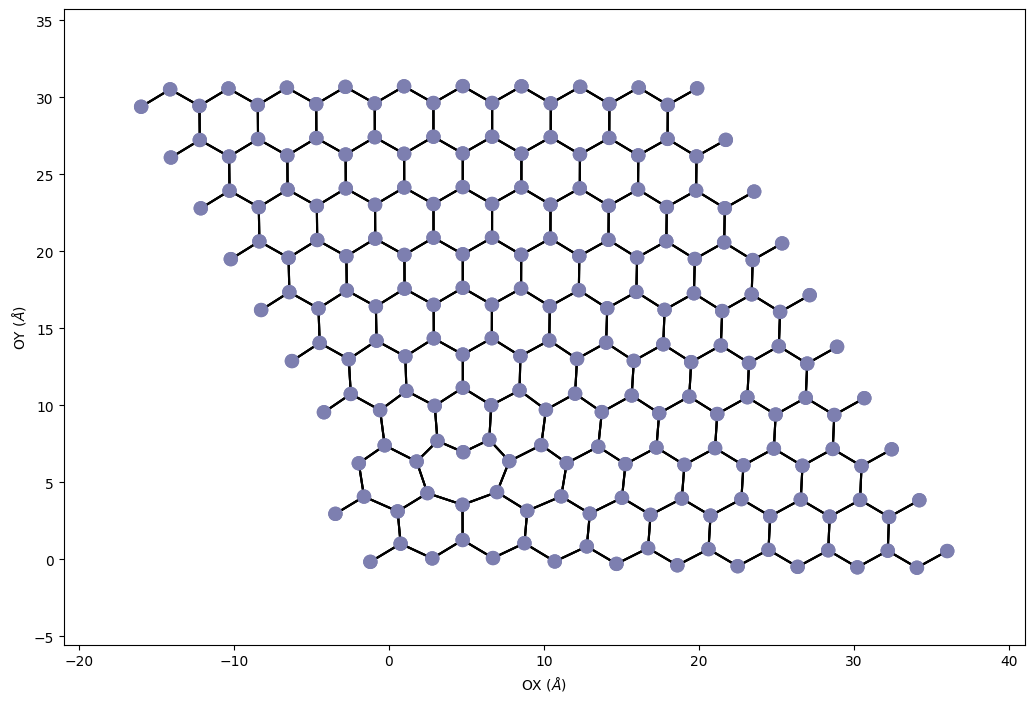

In [8]:
# PIERWSZA DYSLOKACJA

# Set the first dislocation
u0, all_us = displace_love2(
    crystal=l0,
    position=dislocations[0].position,
    burgers_vector=dislocations[0].b,
    plane=dislocations[0].plane,
    bv_fraction=1.0,
)

l1 = l0.translate(u0)
l1 = wzt.generate.update_bonds(l1)
wzt.visualization.plot_atoms_2d(l1)

In [9]:
# DRUGA DYSLOKACJA
dis_1 = dislocations[0]
dis_2 = dislocations[1]

plane_d_x_y, y0 = get_crystal_plane(dis_1, dis_2) # w ukladzie zaczepionym w dis_2
# Obroc dis_2 zgodnie z betami wyznaczonymi przez dis_1
dis_2_rot_matrix = get_rotation_matrix(dis_1, dis_2)
# Obroc wektor burgersa dis_2 o macierz obrotu wynikajaca z dyslokacji dis_1 
dis_2_b = dis_2_rot_matrix[:2, :2].dot(dis_2.b[:2]).squeeze()
orig_norm = np.linalg.norm(dis_2.b)
# Zachowaj oryginalna dlugosc wektora
dis_2_b = dis_2_b/np.linalg.norm(dis_2_b)*orig_norm
dis_2_b = np.asarray(dis_2_b.tolist() + [0])
dis_2 = dataclasses.replace(dis_2, b=dis_2_b)


def update_dislocation(d, ref_d, new_pos=None):
    # Obroc dis_2 zgodnie z betami wyznaczonymi przez dis_1
    rot_matrix = get_rotation_matrix(ref_d, d)
    # Obroc wektor burgersa dis_2 o macierz obrotu wynikajaca z dyslokacji dis_1 
    db = rot_matrix[:2, :2].dot(d.b[:2]).squeeze()
    orig_norm = np.linalg.norm(d.b)
    # Zachowaj oryginalna dlugosc wektora
    db = db/np.linalg.norm(db)*orig_norm
    db = np.asarray(db.tolist() + [0])
    d = dataclasses.replace(d, b=db)
    if new_pos is not None:
        d = dataclasses.replace(d, position=new_pos)
    return d, rot_matrix

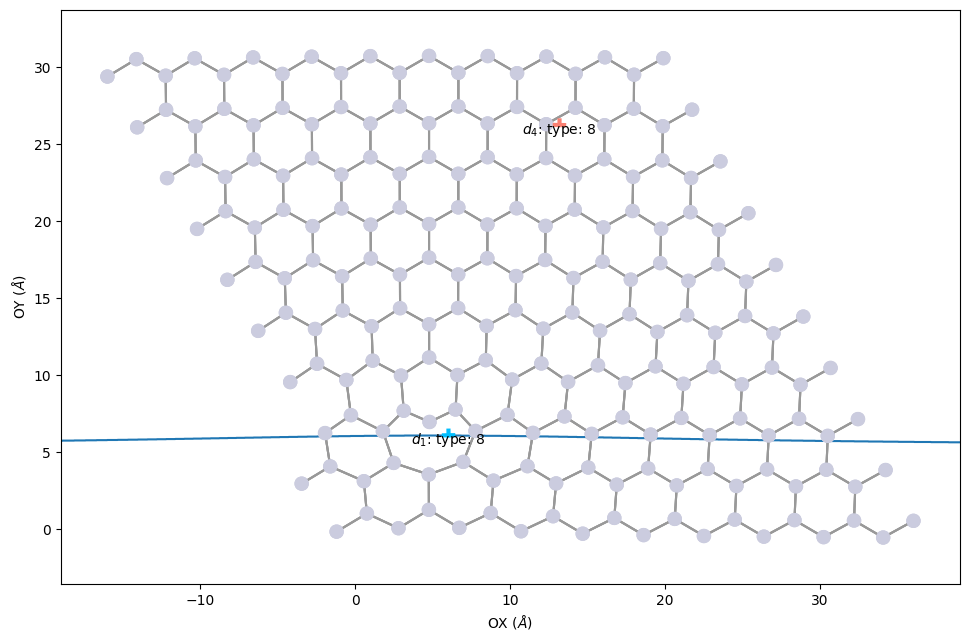

In [10]:
def displace_love2_2nd_dis(
        crystal: Crystal,
        dis_1, dis_2,
        dis1_coordinates=None,
        dis1_rot_matrix=None
) -> Tuple[np.ndarray, np.ndarray]:
    
    position = np.asarray(dis_2.position)
    burgers_vector = np.asarray(dis_2.b)
    plane = np.asarray(dis_2.plane)
    cell = crystal.cell
    bv_fraction = 1.0

    rt = wzt.dislocations._get_rotation_tensor(
        burgers_vector=burgers_vector,
        plane=plane,
        cell=cell
    )
    rt_inv = np.transpose(rt)

    burgers_vector = bv_fraction * cell.to_cartesian_indices(burgers_vector)
    burgers_vector = burgers_vector.reshape(-1, 1)
    burgers_vector = rt.dot(burgers_vector).squeeze()
    be = np.sqrt(burgers_vector[0]**2 + burgers_vector[1]**2)
    bz = burgers_vector[2]

    position = position.reshape(-1, 1)
    cd = rt.dot(position).squeeze()  # (3, )
    
    # Initial setting
    if dis1_coordinates is not None:
        x_all = np.array(dis1_coordinates).reshape(1, 3)
        # TODO is this rotation needed here?
        x_all = rt.dot(x_all.T).T
    else:
        x_all = rt.dot(crystal.coordinates.T).T  # (natoms, 3)
    x_all = x_all-cd.reshape(1, -1)

    def f(u, x):
        nonlocal be, bz, dis_1, dis_2
        current_x = x+u
        current_x = current_x.reshape(1, -1)
        result = get_love_compensation(plane_d_x_y, dis_1, dis_2, point=current_x.squeeze())
        rd, delta_d = result["rd"], result["delta_d"]
        # print(f"delta_d: {delta_d}, point: {point}, angle: {np.arctan2(point[1]-dis_b.position[1], point[0]-dis_b.position[0])}")
        new_u = love_polar((rd, delta_d), be=be, bz=bz)
        return (u-new_u).squeeze()

    def jacobian(u, x):
        nonlocal be, bz, dis1_coordinates, dis1_rot_matrix
        current_x = x + u
        current_x = current_x.reshape(1, -1)
        betas = get_betas(dis_2, current_x.squeeze(), dis_2_rot_matrix)
        if dis1_coordinates is None:
            betas += get_betas(dis_1, current_x.squeeze(), dis1_rot_matrix)
        F_inv = (np.eye(2)-betas)
        ones = np.eye(3)
        ones[:2, :2] = F_inv
        return ones.squeeze()

    if dis1_coordinates is not None:
        result_u = np.zeros((1, 3))
    else:
        result_u = np.zeros((crystal.n_atoms, 3))

    all_us = []
    
    for i, coords in enumerate(x_all):
        u0 = np.zeros(3)
        u, us = newton_raphson(x0=u0, n_iter=1, f=f, jacobian=jacobian, x=coords)
        result_u[i] = u
        all_us.append(np.stack(us))
        
    all_us = np.stack(all_us)  # (n atoms, timestep, 3)
    all_us = np.transpose(all_us, (1, 0, 2))  # (timestep, n atoms, 3)
    # Move to the previous system 
    result_u = rt_inv.dot(result_u.T).T
    return result_u, all_us


# TODO determine new position of d1 in respect to d2 (iterate position of the d1)
# Use the new d1 while finding the new position of crystal cell atoms
dis1_new_pos, dis1_step = displace_love2_2nd_dis(l1, dis_1, dis_2, dis1_coordinates=dis_1.position)

new_dis_1, new_d1_rot_matrix = update_dislocation(d=dis_1, ref_d=dis_2, new_pos=dis_1.position+dis1_new_pos.squeeze())
fig, ax = plt.subplots()
wzt.visualization.plot_atoms_2d(l1, alpha=0.4, offset=3, fig=fig, ax=ax)

wzt.visualization.display_tee_2d(ax, dis_2, scale=0.3, line_width=10)
wzt.visualization.display_tee_2d(ax, new_dis_1, scale=0.3, line_width=10)
plt.plot(plane_d_x_y[0] + dislocations[1].position[0], plane_d_x_y[1] + dislocations[0].position[1])

Reading bond: 1192/1192

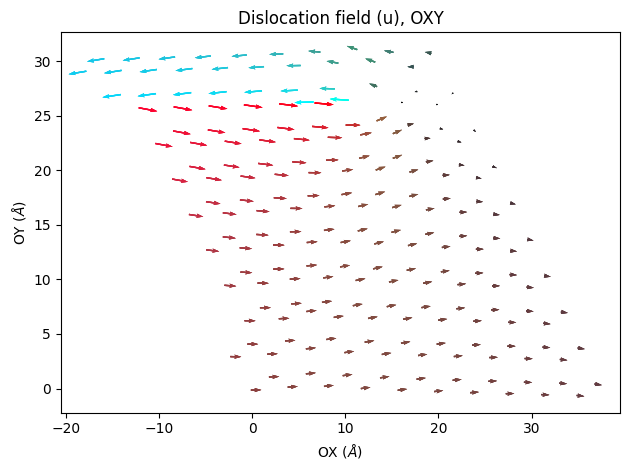

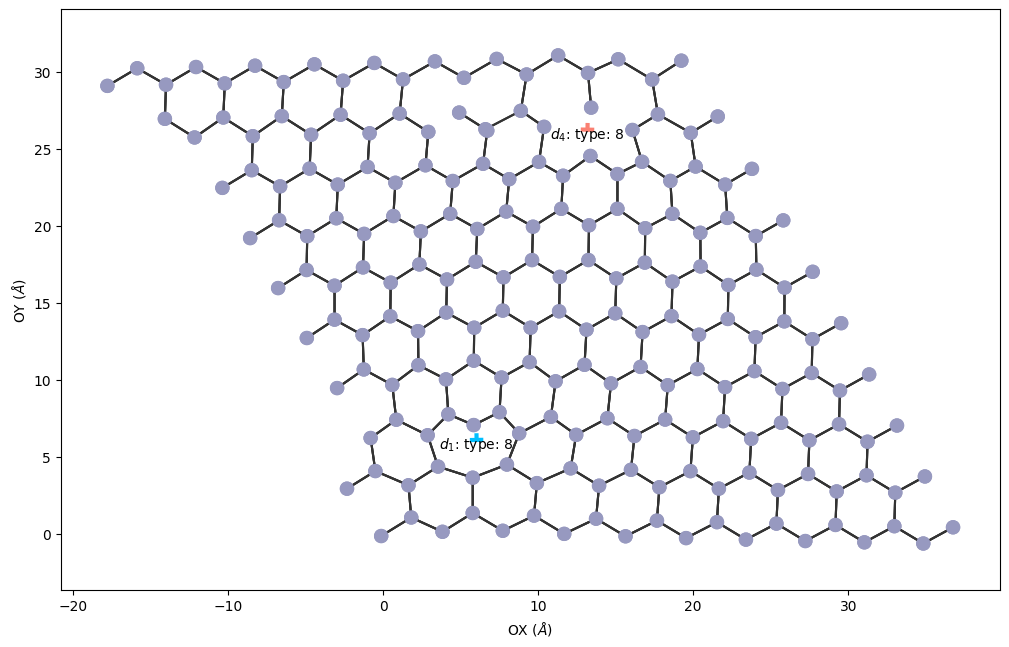

In [11]:
u1, u1s = displace_love2_2nd_dis(l1, new_dis_1, dis_2, dis1_rot_matrix=new_d1_rot_matrix)

l2 = l1.translate(u1)

wzt.visualization.plot_displacement(l2, u1)

fig, ax = plt.subplots()
l2 = wzt.generate.update_bonds(l2)
wzt.visualization.plot_atoms_2d(l2, alpha=0.8, offset=3, fig=fig, ax=ax)

wzt.visualization.display_tee_2d(ax, dis_2, scale=0.3, line_width=10)
wzt.visualization.display_tee_2d(ax, dis_1, scale=0.3, line_width=10)
fig.savefig("multiple-dislocations.png")

In [12]:
# def plot_iteration_step(data, fig, ax):
#     d, F = data
#     wzt.visualization.plot_atoms_2d(l0, alpha=0.4, offset=3, fig=fig, ax=ax)
#     ax.set_aspect("equal")

#     bv_angstrom = l0.cell.to_cartesian_indices(dislocations[0].b)
#     xlim = -12, 15
#     ylim = 0, 10
#     plane_d_x, plane_d_y = wurtzite.dislocations.get_crystal_surface_oxy(position=dislocations[0].position, x0=0.0, y0=y0, xlim=xlim, ylim=ylim, bx=bv_angstrom[0])
#     ax.plot(plane_d_x, plane_d_y, lw=1, ls="--", zorder=1500, color="brown")

#     # d1
#     d1b = F[:2, :2].dot(d.b[:2])
#     d1b = d1b/np.linalg.norm(d1b)
#     d1 = dataclasses.replace(d, b=d1b)
#     display_tee_2d(ax, d1, scale=0.3, line_width=10, label_offset=(1.3, -1))

#     # d2
#     rot_matrix = get_rotation_matrix(dislocations[0], dislocations[1])
#     rot_d2_b = rot_matrix.dot(dislocations[1].b)
#     rot_d2_b = rot_d2_b/np.linalg.norm(rot_d2_b)
#     d2_to_display = dataclasses.replace(dislocations[1], b=rot_d2_b)
#     display_tee_2d(ax, d2_to_display, scale=0.3, line_width=10, label_offset=(1.3, -1))
#     # ax.set_xlim([0, 12])
#     # ax.set_ylim([5, 11])    
    

# from matplotlib import animation
# from IPython.display import HTML


# anim = wurtzite.visualization.create_animation_2d(data=list(zip(d1s, Fs)), plot_function=plot_iteration_step, figsize=(12, 6), interval=200)
# HTML(anim.to_jshtml())
# # anim.save("two-dislocations.gif")

In [13]:
# for d in d1s:
#     print(d.b)
#     fig, ax = wzt.visualization.plot_atoms_2d(l0, alpha=0.1, offset=3)
#     fig.set_size_inches(10, 10)
#     ax.set_aspect("equal")

#     bv_angstrom = l0.cell.to_cartesian_indices(dislocations[0].b)
#     xlim = -12, 15
#     ylim = 0, 10
#     plane_d_x, plane_d_y = wurtzite.dislocations.get_crystal_surface_oxy(position=dislocations[0].position, x0=0.0, y0=y0, xlim=xlim, ylim=ylim, bx=bv_angstrom[0])
#     ax.plot(plane_d_x, plane_d_y, lw=1, ls="--", zorder=1500, color="brown")
#     display_tee_2d(ax, d, scale=0.3, line_width=10, label_offset=(1.3, -1))
#     display_tee_2d(ax, dislocations[1], scale=0.3, line_width=10, label_offset=(1.3, -1))

#     ax.set_xlim([0, 12])
#     ax.set_ylim([5, 13])
#     plt.show()